<a href="https://colab.research.google.com/github/parsidd/screening_tasks_qosf/blob/master/Gautham_QoSF_Task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install cirq --quiet #Install cirq

In [3]:
#Import required modules
import numpy as np
import cirq
from cirq.circuits import InsertStrategy
import sympy
import matplotlib.pyplot as plt

#The Variational Quantum Eigen Solver (VQE)
This is a submission for Task 4. We are required to find the Eigen value of 
$$
H = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & 0 & 1 
\end{bmatrix}
$$
##The Ansatz
We can see that the given matrix has eigen states given by the bell states. Hence, using an Ansatz that generates Bell States and their rotations is very sensible. The Ansatz given in the hint is thus justified and used below. The Ansatz is as shown:


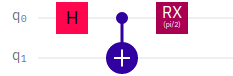
##The Hamiltonian's Circuit
We can decompose $H$ into a sum of Pauli Matrices as shown below:
$$
\begin{equation}
ZZ = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & 0 & 0 & 1 
\end{bmatrix}
\end{equation}
$$
$$
II = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 
\end{bmatrix}
$$
$$
XX = \begin{bmatrix}
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
1 & 0 & 0 & 0 
\end{bmatrix}
$$
$$
YY = \begin{bmatrix}
0 & 0 & 0 & -1 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
-1 & 0 & 0 & 0 
\end{bmatrix}
$$
Thus we can see that 
$$
H = \frac{1}{2}(ZZ + II) - \frac{1}{2}(XX + YY)
$$
This gives us the circuit that we need to use for estimating the Hamiltonian. We need 6 qubits, a pair each for $ZZ$, $XX$ and $YY$. The qubits for $ZZ$ can be measured directly. For $XX$ and $YY$ we need to add rotations of $R_{Y}(-\frac{\pi}{2})$ and  $R_{X}(\frac{\pi}{2})$, to each of the qubits in the respective pairs.

The circuit for the Hamiltonian becomes the following: 
In the code below, we the circuit is created with the components as shown above. The final circuit is: 


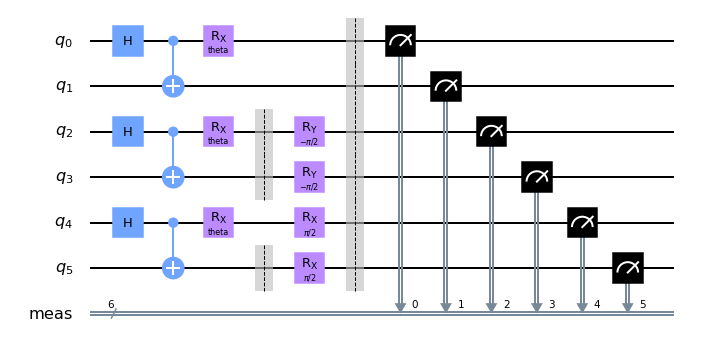

In [72]:
def vqe_circuit():
  '''Creates the Required Quantum circuit, simulates it and calls the function for calculating expectation values'''
  #Create the variational parameter
  theta = sympy.Symbol('theta')
  #Create the qubits
  q = cirq.LineQubit.range(6)

  #Create the circuit
  circuit = cirq.Circuit()
  for i in range(3):
    circuit.append(cirq.H(q[2*i]))
    circuit.append(cirq.CNOT(q[2*i],q[2*i+1]))
    circuit.append(cirq.rx(theta)(q[2*i]))
  circuit.append([cirq.ry(-np.pi/2)(q[2]),cirq.ry(-np.pi/2)(q[3]),cirq.rx(np.pi/2)(q[4]),cirq.rx(np.pi/2)(q[5])],strategy = InsertStrategy.INLINE)
  circuit.append(cirq.measure(*q,key = 'result'), strategy = InsertStrategy.INLINE)
  
  print("The circuit is: ")
  print(circuit)
  print("Sampling the circuit: ")
  #Create the simulator, the parameter sweep and perform simulation
  s = cirq.Simulator()
  param_sweep = cirq.Linspace('theta', start = 0, stop = 2*np.pi, length = 200)
  trials = s.run_sweep(circuit, param_sweep, repetitions = 1000)
  
  #Extract the required data for the plot
  angles = np.array([trial.params['theta'] for trial in trials])
  expectations = np.array([expectation(trials[i].measurements['result'].astype('int')) for i in range(200)]) 
  #We need to convert values from uint8 to int so that we can scale the values to the range {-1,1}

  #Plot the results
  plt.plot(angles,expectations)
  plt.xlabel("Angle in radians")
  plt.ylabel("Expectation value of Hamiltonian")
  plt.title("Value of Hamiltonian as a function of the angle in the ansatz")
  plt.show()
  return circuit

We have to calculate the expectation value of the Hamiltonian from the measurements that we make on the circuit. Consider the following
$$
\left\langle \psi \right | H \left |\psi \right \rangle = 0.5 \left 
(
\left\langle \psi \right | ZZ \left |\psi \right \rangle +
\left\langle \psi \right | II \left |\psi \right \rangle +
\left\langle \psi \right | XX \left |\psi \right \rangle -
\left\langle \psi \right | YY \left |\psi \right \rangle 
\right )
$$
This simplifies to 
$$
\left\langle \psi \right | H \left |\psi \right \rangle = 0.5 + 0.5 \left (
\left\langle \psi \right | ZZ \left |\psi \right \rangle -
\left\langle \psi \right | XX \left |\psi \right \rangle -
\left\langle \psi \right | YY \left |\psi \right \rangle 
\right ) \\ \\
$$ 
Since we add rotations of $R_{Y}(-\frac{\pi}{2})$ and  $R_{X}(\frac{\pi}{2})$ for the $XX$ and $YY$ estimation, we can just measure $ZZ$ for each pair of qubits. However, measuring $Z_{1}Z_{2}$ amounts to measuring $Z_{1}$ and $Z_{2}$ separately and then multiplying them. Thus we do

```
0.5*(i[0]*i[1] - i[2]*i[3] - i[4]*i[5]) + 0.5 
```
where the index denotes the index of the qubit as in the circuit shown above.


In [73]:
def expectation(measurements):
  '''Returns the expectation value of the Hamiltonian, given an array of single shot measurements'''
  #Convert from {0,1} values to {-1,1} 
  measurements = 2*np.array(measurements) - 1 
  
  #Expectation(Z_1*Z_2) = Expectation(Z_1)*Expectation(Z_2)
  return sum([0.5*(i[0]*i[1] - i[2]*i[3] - i[4]*i[5]) + 0.5 for i in measurements])/measurements.shape[0]

We now run the code and we can see from the graph that the lowest eigen value of the given Hamiltonian is -1, which is reached at a value of $\theta = \pi$, We have thus succesfully estimated an upper bound for the lowest eigen value using VQE!



The circuit is: 
0: ───H───@───Rx(theta)───────────────M('result')───
          │                           │
1: ───────X───────────────────────────M─────────────
                                      │
2: ───H───@───Rx(theta)───Ry(-0.5π)───M─────────────
          │                           │
3: ───────X───────────────Ry(-0.5π)───M─────────────
                                      │
4: ───H───@───Rx(theta)───Rx(0.5π)────M─────────────
          │                           │
5: ───────X───────────────Rx(0.5π)────M─────────────
Sampling the circuit: 


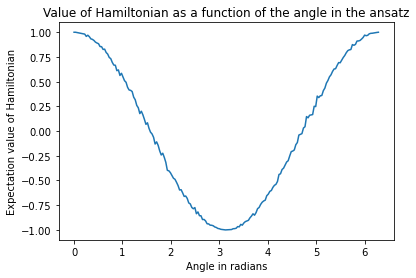

In [74]:
a = vqe_circuit()

We can verify this with the eigen values calculated from another eigen solver

```
numpy.linalg.eig()
```
As we can see below, we got the right value!! And that the eigen states are the bell states. 

In [53]:
H = np.array([[1,0,0,0],[0,0,-1,0],[0,-1,0,0],[0,0,0,1]])
w,v = np.linalg.eig(H)
print(w)
print(v)

[ 1. -1.  1.  1.]
[[ 0.          0.          1.          0.        ]
 [-0.70710678  0.70710678  0.          0.        ]
 [ 0.70710678  0.70710678  0.          0.        ]
 [ 0.          0.          0.          1.        ]]
